In [2]:
from music21 import *
import pandas as pd
import numpy as np
import music21
import math

C:\Users\brian\AppData\Local\Temp\ipykernel_4404\1389054962.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [13]:
class AudioAnalysis:

    '''
    This class takes a pandas DataFrame representing the correct and incorrect notes respectively played by a solo instrument
    and converts it into a music21 score that highlights any mistakes in intonation, ignoring issues in time.
    '''
    
    def __init__(self, input_df: pd.DataFrame, score: str):
        # self.correct_df = correct_df
        self.input_df = input_df
        self.score = converter.parse(score)
        self.correct_df = None
    
    def generate_dataframe_from_score(self) -> None:

        """
        Given a score that has been converted to a music21.stream.Score object, this method extracts information from the
        score about the notes in the score and displays it as a pandas DataFrame.
        """

        beats = self.score.getTimeSignatures(recurse=True)[0].numerator
        measures = int(math.ceil(self.score.highestTime / beats)) + 1
        durations = []
        is_chord = []
        for i in range(1, measures, 1):
            measure = self.score.parts[0].measure(i).flatten().notesAndRests
            lengths = []
            for j in range(0, len(measure)):
                s = measure[j].duration.quarterLength
                is_chord.append(False)
                lengths.append(float(s))
            durations.append(lengths)
        measure_notes = []
        measure_notes_frequency = []
        for i in range(1, measures, 1):
            measure = self.score.parts[0].measure(i).flatten().notesAndRests
            notes = []
            notes_frequency = []
            for j in range(0, len(measure)):
                if (measure[j].isChord):
                    chord = measure[j].notes
                    notes.append(str(chord[-1].pitch.name + str(chord[-1].pitch.octave)))
                    notes_frequency.append(chord[-1].pitch.frequency)
                    continue
                elif (measure[j].isRest):
                    s = 'rest'
                    f = 0.0
                else:
                    f = measure[j].pitch.frequency
                    s = str(measure[j].pitch.name)
                    s += str(measure[j].pitch.octave)
                notes.append(s)
                notes_frequency.append(f)
            measure_notes.append(notes)
            measure_notes_frequency.append(notes_frequency)
        # bpm = 260
        # quarter_note_duration = (1 / bpm) * 60
        # note_duration = []
        # for measure in durations:
        #     note_duration.append([note_length * quarter_note_duration for note_length in measure])
        new_durations = np.concatenate(durations)
        new_measure_notes = np.concatenate(measure_notes)
        new_measure_notes_frequency = np.concatenate(measure_notes_frequency)
        # new_note_duration = np.concatenate(note_duration)

        start_times = []
        start_times.append(0)
        # curr_time = 0

        # for i in range(0, len(new_note_duration) - 1):
        #     curr_time += new_note_duration[i]
        #     start_times.append(curr_time)

        note_type = [duration.Duration(quarterLength=quarter_note_length).type for quarter_note_length in new_durations]
        df = pd.DataFrame({'Note Type': note_type,
                   'Note Name': new_measure_notes, 'Note Frequency': new_measure_notes_frequency})
        self.correct_df = df

    def compare_dataframe(self) -> pd.DataFrame:
        """
        Compares the two dataframes representing correct notes and notes played by the user and appends information
        comparing differences to a new dataframe so notes with wrong intonation can be easily identified.
        """
        self.generate_dataframe_from_score()
        correct_notes = list(self.correct_df['Note Name'])
        input_notes = list(self.input_df['Note Name'])
        is_correct = []
        for i in range(len(input_notes)):
            if correct_notes[i] == input_notes[i]:
                is_correct.append(True)
            else:
                is_correct.append(False)
        new_df = self.correct_df
        for i in range(len(correct_notes) - len(input_notes)):
            is_correct.append(False)
            input_notes.append(math.nan)
        new_df.insert(3, "Played Notes", input_notes)
        new_df.insert(4, "Correct", is_correct)
        return new_df
    
    def generate_overlay_score(self):
        """
        Takes information from a DataFrame that shows differences between expected and played notes and generates
        a new score from it. Notes with incorrect intonation are displayed together, and the wrong note is colored in red. 
        """
        df = self.compare_dataframe()
        new_score = stream.Stream()
        correct_notes = df['Note Name']
        is_correct = df["Correct"]
        input_notes = df['Played Notes']
        time_signature = self.score.getTimeSignatures()[0].ratioString
        new_score.append(meter.TimeSignature(time_signature))
        for i in range(len(is_correct)):
            print(input_notes[i])
            if str(input_notes[i]) == 'nan':
                continue
            if is_correct[i]:
                new_note = music21.note.Note(correct_notes[i])
                new_note.duration.type = 'quarter'
                new_score.append(new_note)
            else:
                correct_note = music21.note.Note(correct_notes[i])
                incorrect_note = music21.note.Note(input_notes[i])
                correct_note.duration.type = 'quarter'
                incorrect_note.duration.type = 'quarter'
                incorrect_note.style.color = 'red'
                combined_chord = music21.chord.Chord([correct_note, incorrect_note])
                new_score.append(combined_chord)
        new_score.show()
        new_score.write('xml', 'overlayed_score.xml')
        
        
        
        


In [14]:
notes = ['A4', 'G4', 'F4', 'F4', 'E4', 'E4', 'D4']
freqs = [442.548894, 394.266242, 349.228231, 349.228231, 329.627557, 329.627557, 293.664768]
times = [0.928798, 2.925714, 3.924172, 4.922630, 5.921088, 6.919546, 7.918005]

my_dict = {'Note Name': notes, 'Frequency': freqs, 'Times': times}
df = pd.DataFrame(data=my_dict)


In [15]:
testing = AudioAnalysis(df, "C:\\Users\\brian\\Desktop\\VIP\\Evaluator-code\\src\\score\\twinkle.musicxml")

A4
G4
F4
F4
E4
E4
D4
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


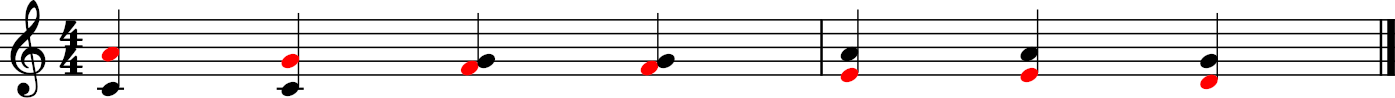

,Note Type,Note Name,Note Frequency,Played Notes,Correct
0,quarter,C4,261.625565,A4,False
1,quarter,C4,261.625565,G4,False
2,quarter,G4,391.995436,F4,False
3,quarter,G4,391.995436,F4,False
4,quarter,A4,440.000000,E4,False
5,quarter,A4,440.000000,E4,False
6,half,G4,391.995436,D4,False
7,quarter,F4,349.228231,NaN,False
8,quarter,F4,349.228231,NaN,False
9,quarter,E4,329.627557,NaN,False


In [16]:
testing.generate_overlay_score()
new_df = testing.compare_dataframe()
new_df

In [ ]:
math.nan

nan